# Draft for HW 5
Progress:
1. Eigenvalues and Power Iterations
    * ~~(a) done~~
    * (b) 
        * Need to compare as a function of iterations
        * make plots
    * (c)
        * **Better way to find the initial guesses???**
        * make plots to compare accuracy
    * (d) 
        * **I THINK I NEED TO ORTHOGONALIZE FIRST?**
        * compare as function
        * make b plots
        * make c plots


2. Yale Faces
    * CHECK CORRELATION MATRIX IS RIGHT
    * (a) last plot? of the eigenfaces?
    * (b) **haven't started**
    * (c) **haven't started**
    

In [2]:
import cv2 
import math
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import linalg
import scipy


Note that the data for the Yale faces datasets can be found on the course website in the "Homework + Data + Text" section: https://faculty.washington.edu/kutz/am584/am584.html. 
        

In [3]:
main_dir = '/Users/jmnugent/Documents/__Year_3_2020-2021/AMATH_584-Numerical_Linear_Algebra/Homework/python/'

crop_dir = main_dir + 'CroppedYale/'
uncrop_dir = main_dir + 'yalefaces_uncropped/yalefaces/'
save_dir = main_dir + 'amath584/hw5_iterative_methods/'


## Define Functions

In [4]:
def power_iteration(A, tol=1e-6, num_iter=None, stop=1e6):
    """
    Performs power iteration on input matrix A (m x m) until the
    gradient of the Rayleigh quotient is less than or equal to the
    tol (default: 1e-6). If num_iter is given, will perform a set 
    number of iterations (and not necessarily go until the tolerance is reached).
    
    Assumes A is squre. The initial guess is a randomized vector of unit length.
    
    Returns the largest eigenvalue and its corresponding eigenvector after iteration is
    complete. If num_iter=None, also returns how many iterations it took to
    reach the tolerance.
    
    Stops after 'stop' iterations to prevent an infinite loop.
    """
    # functions for the Rayleigh quotient and its gradient
    r = lambda x: (x.T @ A @ x) / (x.T @ x)
    gradr = lambda x: (2 / (x.T @ x)) * ((A @ x) - (r(x)*x))
    
    # get size m
    m = A.shape[0]

    # iterate some number of times
    if num_iter is not None:
        if type(num_iter) != int:
            raise Exception('Invalid input for num_iter! Must be an integer # of iterations.')
        else:
            # initialize
            lk = np.zeros(num_iter, dtype=complex)
            vk = np.zeros((num_iter, m, 1), dtype=complex)
            
            v0 = np.random.randn(m, 1)
            v0 = v0 / np.linalg.norm(v0)
            vk[0, :] = v0
            lk[0] = v0.T @ A @ v0
            
            # iterate
            for k in range(num_iter-1):
                w = A @ vk[k, :]
                vk[k+1, :] = w / np.linalg.norm(w)
                lk[k+1] = vk[k+1, :].T @ A @ vk[k+1, :]

            return [lk[-1], vk[-1, :]]
    
    # iterate until you reach some value
    else: 
        # initialize
        n = 0
        vk = np.random.randn(m, 1)
        vk = vk / np.linalg.norm(vk)
        lk = vk.T @ A @ vk
        
        # iterate
        while np.any(np.abs(gradr(vk)) > tol):
            if n > stop:
                print('STOPPED AFTER ' + str(int(stop)) + ' ITERATIONS')
                return [float(lk), vk, n]
                break
            n += 1
            w = A @ vk
            vk = w / np.linalg.norm(w)
            lk = vk.T @ A @ vk
        
        return [lk[0][0], vk, n]
    
    

In [5]:
def rq_iteration(A, v0, tol=1e-6, num_iter=None, stop=1e6):
    """
    Performs Rayleigh Quotient iteration on input matrix A (m x m)
    for some initial guess of eigenvector v0 (m x 1) until the difference
    between lambda(k-1) and lambda(k) < tol. If num_iter is given, will
    perform a set number of iterations (and not necessarily go until the
    tolerance is reached).
    
    Assumes A is square.
    
    Returns the found eigenvalue and its corresponding eigenvector after iteration is
    complete. If num_iter=None, also returns how many iterations it took to
    reach the tolerance.
    
    Stops after 'stop' iterations to prevent an infinite loop.
    """
    # functions for the Rayleigh quotient and its gradient
    r = lambda x: (x.T @ A @ x) / (x.T @ x)
    gradr = lambda x: (2 / (x.T @ x)) * ((A @ x) - (r(x)*x))
    
    # get size m
    m = A.shape[0]
    
    # initialize arrays
    eigs = np.zeros(m, dtype=complex)
    vecs = np.zeros((m, m), dtype=complex)
    
    # iterate some number of times
    if num_iter is not None:
        if type(num_iter) != int:
            raise Exception('Invalid input for num_iter! Must be an integer # of iterations.')
        else:
            # initialize
            lk = np.zeros(num_iter, dtype=complex)
            vk = np.zeros((num_iter, m, 1), dtype=complex)
            vk[0, :] = v0
            lk[0] = v0.T @ A @ v0
            
            # iterate
            for k in range(num_iter-1):
                w = np.linalg.solve((A - lk[k]*np.eye(m)), vk[k, :])
                vk[k+1, :] = w / np.linalg.norm(w)
                lk[k+1] = vk[k+1, :].T @ A @ vk[k+1, :]
                
            return [lk[-1], vk[-1, :]]
            
    # iterate until the difference is very small
    else:
        # initialize
        l0 = v0.T @ A @ v0
        
        # first iteration
        n = 1
        w = np.linalg.solve((A - l0*np.eye(m)), v0)
        vk = w / np.linalg.norm(w)
        lk = vk.T @ A @ vk
        
        # iterate until lambdas are equal within the tolerance
        lk_prev = l0
        while np.abs(lk - lk_prev) > tol:
            n += 1
            if n > stop:
                print('STOPPED AFTER ' + str(int(stop)) + ' ITERATIONS')
                return [lk[0][0], vk, n]
                break
            lk_prev = lk
            try:
                w = np.linalg.solve((A - lk*np.eye(m)), vk)
            except:
                return [float(lk), vk, n]
                break
            vk = w / np.linalg.norm(w)
            lk = vk.T @ A @ vk            

        return [lk[0][0], vk, n]
    

In [6]:
def rand_unitvec(m):
    """Generate a random mx1 vector of unit length.
    """
    v = np.random.randn(m, 1)
    v1 = v / np.linalg.norm(v)
    
    return v1


# 1. Eigenvalues and Power Iterations

## part (a)
Generate a random, symmetric matrix A which is mxm where m=10. Use the EIGS command (**scipy.linalg.eig**) to give you the _ground truth_ eigenvalues and eigenvectors

Used suggestion from here to make the random matrix symmetric: https://stackoverflow.com/questions/10806790/generating-symmetric-matrices-in-numpy

In [ ]:
# build the matrix
m = 10
A_nonsymm = np.random.randn(m, m)
A = np.tril(A_nonsymm) + np.tril(A_nonsymm, -1).T

# check symmetric
print(np.all(A == A.T))

# ground truth
eigvals, eigvecs = scipy.linalg.eig(A)


In [ ]:
print(eigvals)

## part (b)
Find the largest eigenvalue with the **power iteration** method. Compare the accuracy of the method as a function of iterations.

In [ ]:
# function to find gradient of the rayleigh quotient
r = lambda x: (x.T @ A @ x) / (x.T @ x)
gradr = lambda x: (2 / (x.T @ x)) * ((A @ x) - (r(x)*x))
   
# to check for accuracy, this should be true
tol = 1e-6
is_close = lambda x: np.all(np.abs(gradr(x)) < tol)


##### Test it on a few things!

In [ ]:
lambda1, v1, n = power_iteration(A, tol=tol)
print(lambda1)
print(is_close(v1))
print(n, 'iterations')

lambda2, v2 = power_iteration(A, num_iter=100)
print('\n', lambda2)
print(is_close(v2))
print('100 iterations')

lambda3, v3 = power_iteration(A, num_iter=10000)
print('\n', lambda3)
print(is_close(v3))
print('10,000 iterations')


In [ ]:
# the true largest eigenvalue
print(np.max(np.abs(eigvals)))

### Make plots

"Find the largest eigenvalue with the **power iteration** method. Compare the accuracy of the method as a function of iterations." (_What happens to v(k) as k gets big? What is v converging to?_)

In [ ]:
# TODO

## part (c)

Find all 10 eigenvalues by **Rayleigh Quotient** iteration and guessing initial "eigenvectors." Compare the accuracy of the method as a function of iterations and discuss your initial guesses to find all eigenvalue/eigenvector pairs.

##### ...actually guess...!!

In [ ]:
# ?????

##### Loop to get all 10 unique values
NOTE: this only works as written for symmetric matrices A because you know the eigenvalues are unique!

In [ ]:
# initialize list of eigenvalues with an array because it
# gets returned as a float
eigs_rq = np.zeros(1)

# perform one iteration to find an eigenvalue/eigenvector pair
eigs_rq[0], vecs_rq, n = rq_iteration(A, rand_unitvec(m))
print(n, 'iterations')

# repeat the iteration until you find all 10 unique ones;
# check for uniqueness to 6 decimal points (because tol=1e-6)
while len(eigs_rq) < 10:
    eig, vecs, nn = rq_iteration(A, rand_unitvec(m), tol=1e-6)
    if np.round(eig, 6) not in np.round(eigs_rq, 6):
        print(n, 'iterations')
        eigs_rq = np.append(eigs_rq, eig)
        vecs_rq = np.append(vecs_rq, vecs, axis=-1)
        

In [ ]:
# try with some others...
e2, v2 = rq_iteration(A, rand_unitvec(m), num_iter=2)
print(e2)

e3, v3 = rq_iteration(A, rand_unitvec(m), num_iter=3)
print(e3)

e5, v5 = rq_iteration(A, rand_unitvec(m), num_iter=5)
print(e5)


##### quick check that you got all 10!

In [ ]:
print('From Rayleigh Quotient iteration:')
# print(sorted(eigs_rq, key=abs)[::-1])
for x in eigs_rq: print(x)

print('\nGround truth:')
for x in eigvals: print(x)


### Plot...

In [ ]:
# TODO

## part (d)
Repeat (b) and (c) with a **random matrix** that is not symmetric. Be sure to plot the eigenvalue in the complex plane.

In [ ]:
# build the matrix
m = 10
A_ns = np.random.randn(m, m)
A_ns_list = [np.random.randn(m, m) + np.random.randn(m, m)*1j]*m

# ground truth
eigvals_ns, eigvecs_ns = scipy.linalg.eig(A_ns)
eigvals_ns_list = [scipy.linalg.eig(A)[0] for A in A_ns_list]
eigvecs_ns_list = [scipy.linalg.eig(A)[1] for A in A_ns_list]


#### part (b), non-symmetric

In [ ]:
# I think I need to do some kind of orthogonalization first??
# check notes in AM

In [ ]:
%%time 

for a in A_ns_list:
#     lambda_ns, v_ns, n_ns = power_iteration(a, tol=1e-6, stop=1e6)
    lambda_ns, v_ns = power_iteration(a, tol=1e-6, stop=1e6, num_iter=100000)
    print(lambda_ns)
    print(is_close(v_ns))
#     print(n_ns)
    print('---')


In [ ]:
# ...not sure what the difference here will be... just more iterations
# needed? 

# do I need to make sure the initial guess is complex??


#### part (c), non-symmetric

In [ ]:
%%time
# ACTUALLY GUESS for Rayleigh stuff! (not this)

v0c = np.random.randn(m, 1) + np.random.randn(m, 1)*1j
v0c = v0c / np.linalg.norm(v0c)

# te, tv, tn = rq_iteration(A_ns, v0c, tol=1e-6, stop=1e6)
# print(te)
# print(tn)


#### Try this for 10 different matrices

In [ ]:
%%time

for A_ns in A_ns_list:
    te, tv, tn = rq_iteration(A_ns, v0c, tol=1e-6, stop=1e5)
    print(np.round(te, 6) in np.round(A_ns, 6))
    print(tn, 'iterations')
    print('---')


In [ ]:
# ALSO NOT SURE WHAT TO DO HERE!
# Why is it not working?? None of these converge...


# 2. Yale Faces

## Read in the data:

### Cropped:

In [7]:
# get a list of paths to each subfolder in CroppedYale
paths = [crop_dir + dirname for dirname in os.listdir(crop_dir)
         if os.path.isdir(os.path.join(crop_dir, dirname))]

# initialize list to hold the averaged data matrices for each image
n_img = len(paths)
cropped_pics = [[]]*n_img
cropped_avgs = [[]]*n_img

for i in range(n_img):
    # get the list of file names within the subfolder for that image
    subfolder = paths[i] + '/'
    imagenames = [subfolder + f for f in os.listdir(subfolder)
                  if os.path.isfile(os.path.join(subfolder, f))]
    
    # make one list containing the data matrices for each (grayscale) image 
    cropped_pics[i] = [cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2GRAY) for x in imagenames]

    # averaged the data matrix for this image and add to the list
    cropped_avgs[i] = np.mean(cropped_pics[i], axis=0)
    

In [8]:
# stack so each image is one column in the data matrix
all_pics_c = [cropped_pics[i][j].flatten() for i in range(len(cropped_pics))
              for j in range(len(cropped_pics[i]))]
A_yf = np.transpose(np.asarray(all_pics_c))

print(A_yf.shape)


(32256, 2432)


# TODO: need to make sure you're computing the correlation matrix correctly!

In [9]:
%%time
# get the square correlation matrix

C_yf = A_yf.T @ A_yf # is this right? gives 2432 x 2432
# C_yf2 = A_yf @ A_yf.T # this would give ~32k x ~32k, but takes WAY TOO LONG

print(C_yf.shape)


(2432, 2432)
CPU times: user 2min 3s, sys: 1.85 s, total: 2min 4s
Wall time: 2min 34s


## part (a)
**Power iterate** on the matrix of images to find the dominant eigenvector and eigenvalue. Compare to the leading order SVD mode.

In [10]:
%%time 
# iterate on the subsetted matrix

l_data, v_data, n_data = power_iteration(C_yf)

print('took', n_data, 'iterations')


took 8 iterations
CPU times: user 689 ms, sys: 353 ms, total: 1.04 s
Wall time: 644 ms


In [11]:
# function to find gradient of the rayleigh quotient
r = lambda x: (x.T @ C_yf @ x) / (x.T @ x)
gradr = lambda x: (2 / (x.T @ x)) * ((C_yf @ x) - (r(x)*x))
   
# to check for accuracy, this should be true
tol = 1e-6
is_close = lambda x: np.all(np.abs(gradr(x)) < tol)


In [12]:
print(l_data)
print(gradr(v_data))
print(is_close(v_data))


309952.1007711205
[[ 8.70022632e-09]
 [ 4.54820110e-08]
 [-1.16742740e-07]
 ...
 [ 1.79170456e-09]
 [-4.54747351e-09]
 [ 3.12575139e-08]]
True


In [13]:
%%time 
# perform (economy) SVD

[Uh, Sh, VTh] = np.linalg.svd(C_yf, full_matrices=False) 


CPU times: user 10.7 s, sys: 550 ms, total: 11.3 s
Wall time: 7.62 s


In [14]:
# check that the dimensions are correct

print(C_yf.shape, Uh.shape, Sh.shape, VTh.shape)


(2432, 2432) (2432, 2432) (2432,) (2432, 2432)


#### COMPARE VALUES

In [102]:
print(Sh[0], l_data)
print(Sh[0] - l_data)


309952.10077112046 309952.1007711205
-5.820766091346741e-11


#### PLOTS

Plot the eigenvalue spectrum for the SVD and mark the eigenvalue you get from power iterations

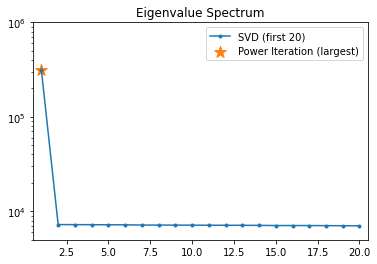

In [58]:
n_eigs = 20

plt.scatter(1, l_data, color='C1', marker='*', s=150, label='Power Iteration (largest)')
plt.plot(np.arange(1, n_eigs+1), Sh[:n_eigs], marker='.',color='C0', label='SVD (first {})'.format(n_eigs))

plt.title('Eigenvalue Spectrum')
plt.legend()
plt.yscale('log')
xmax = n_eigs + 0.5
plt.xlim((0.5, xmax))
plt.ylim((5e3, 1e6))

plt.savefig(save_dir + '2a_eigenvalue_spectra.png', dpi=300, bbox_inches='tight')

plt.show()


Plot the difference in leading eigenvectors magnitude as a bar chart... with index on x axis and value of the vector on the y axis

In [98]:
# reshape first to match the shape of Uh[:, 0]
v_data_rs = np.reshape(v_data, (len(v_data)))

# This is true if the power iteration vector & SVD vector
# have opposite signs
print(np.all(np.sign(v_data_rs) == -np.sign(Uh[:, 0])))

# find the difference in magnitude at each row
vdiff = np.abs(v_data_rs) - np.abs(Uh[:, 0])


True


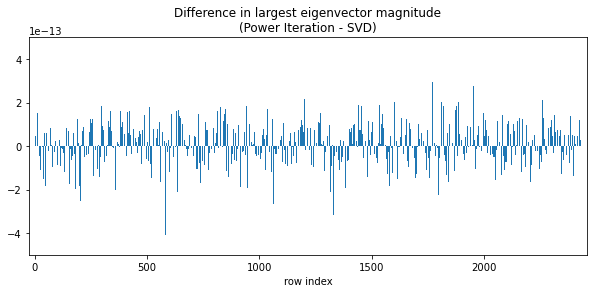

In [101]:
# plot the difference

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(np.arange(1, len(vdiff)+1), vdiff)
ax.set_title('Difference in largest eigenvector magnitude\n(Power Iteration - SVD)')
ax.set_ylim(-.5e-12, .5e-12)
ax.set_xlim(-25, len(vdiff)+25)
ax.set_xlabel('row index')

plt.savefig(save_dir + '2a_diff_in_eigenvector_mag.png', dpi=300, bbox_inches='tight')

plt.show()


# TODO?

Plot the first eigenfaces for power iteration & SVD, which are the first eigenvectors. Label each plot with the eigenvalue.


In [ ]:
# # get dimensions from the first pic
# r, c = cropped_pics[0][0].shape

# # get the eigenfaces (vectors) and reshape
# eigenfaces = [np.reshape(Uh[:, i], (r, c)) for i in range(Uh.shape[1])]
# eigenface_data = np.reshape(v_data, (r, c))

# plot the face
# fig, [axd, axs] = plt.subplots(1, 2, figsize=(12, 6))

# axs.imshow(eigenfaces[0], cmap='gray', label='eigenvalue = {}'.format(Sh[0]))
# axs.set_title('SVD on Data Matrix')
# axs.axis('off')

# axd.imshow(eigenface_data, cmap='grey', label='eigenvalue = {}'.format(l_data))
# axd.set_title('Power Iterations on Correlation Matrix')
# axd.axis('off')

# plt.savefig(save_dir + '2a_eigenvectors_power_vs_svd.png', dpi=300, bbox_inches='tight')

# plt.show()


## part (b)
Use **randomized sampling** to reproduce the SVD matrices: U, $\Sigma$, and V

Recall the process:

1. (stage A) Construct Q (m x k) - reduce from n to k columns

    * take data & randomly sample column space (A Omega = Y)
    * perform (economy) QR on Y to get Q
    
    
2. (stage B) Construct B = Q^T A - take A and project into column space


3. SVD on B matrix to get Utilde, Stilde, V*(tilde)


4. Project backup:
    * U = Q Utilde
    * V = Q Vtilde
    * Sigma = Q Stilde

**NOTE**: coding parts are
* 11/25, 25:00-30:00
* 11/30, 9:50-41:26

## part (c)
Copare the randomized modes to the true modes along with the singular value decay as a function of the number of randomized samples